# CompRobo Computer Vision Project
#### Ari Porad, CompRobo (Independent Study), Spring 2022

## Introduction

For this project, I was tasked with exploring the computer vision algorithm of my choice. I opted for visual odometry, or the process of determining how fast and in what direction a robot is moving using only a camera.

My approach for this project was drawn from _Mastering OpenCV with Practical Computer Vision Projects (2012)_ by Baggio et al., with additional help from [this tutorial on bundle adjustment in SciPy][scipy-tutorial], Google, and, of course, my independent study advisor Paul Ruvolo.

I'm using the [KITTI Odometry][kitti] dataset, which includes camera images and location ground-truth.

Note that the convention used throughout this project is that the Z-axis points forward out of the camera, the X-axis points right, and the Y-axis points down. Since the KITTI dataset is designed for self-driving cars, and cars don't go up or down all that much, the Y-axis is mostly noise and shouldn't be focused on. Instead, focus on the Z-axis (forward) and the X-axis (turning).

To begin, the cells below setup Jupyter and run the odometry system. Afterwards, I'll walk through each step with graphs and explanations.

[scipy-tutorial]: https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html
[kitti]: http://www.cvlibs.net/datasets/kitti/eval_odometry.php

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from graphics import RealGraphicsContext
from main import VOdom

np.set_printoptions(suppress=True) # No scientific notation


In [2]:
# This cell usually takes about 10 seconds to run
gctx = RealGraphicsContext()
vodom = VOdom.kitti(sequence=1, start=0, stop=50, step=1, gctx=gctx)
print("Running...")
vodom.run()
print("Done")

Running...
Median error: X: 98.4%, Y: 57.7%, Z: 205.0%
Done


## Walkthrough

The odometry system has the following steps, each explained in more detail below:

1. For each frame:
	1. Use OpenCV's SIFT algorithm to find features in the frame, then compare those features to the previous frame.
	2. Using only features that were found in both this frame and the previous one, triangulate the essential matrix representing the relative orientation of each camera.
2. ~~Run bundle adjustment to increase accuracy.~~ This step is currently skipped because it's broken, and I haven't had time to fix it.
3. Calculate a scale factor for each frame, using the ground truth.
4. Calculate the error for each frame, by comparing the ground truth to the scaled calculated position.

### Step 1: Feature Detection & Essential Matrix Triangulation

This step is performed between each frame and the frame that proceeded it. The desired output is the essential matrix, which represents the rotation and translation of the second frame relative the first—giving us an estimate for how the camera has moved.

Notably, the essential matrix can't convey scale: the translation vector always has magnitude 1. Determining the scale is done later, in Step 4.

This is done by using OpenCV's SIFT algorithm to identify features in each frame, then filtering to only features that match between the two frames. Those matches are then used to infer the relative position of the two cameras.

Here's an example of two frames, and some of the features that OpenCV and matched between the two (note that only some of the matches are shown, because otherwise it's an unintelligible blob of color):

<IPython.core.display.Javascript object>


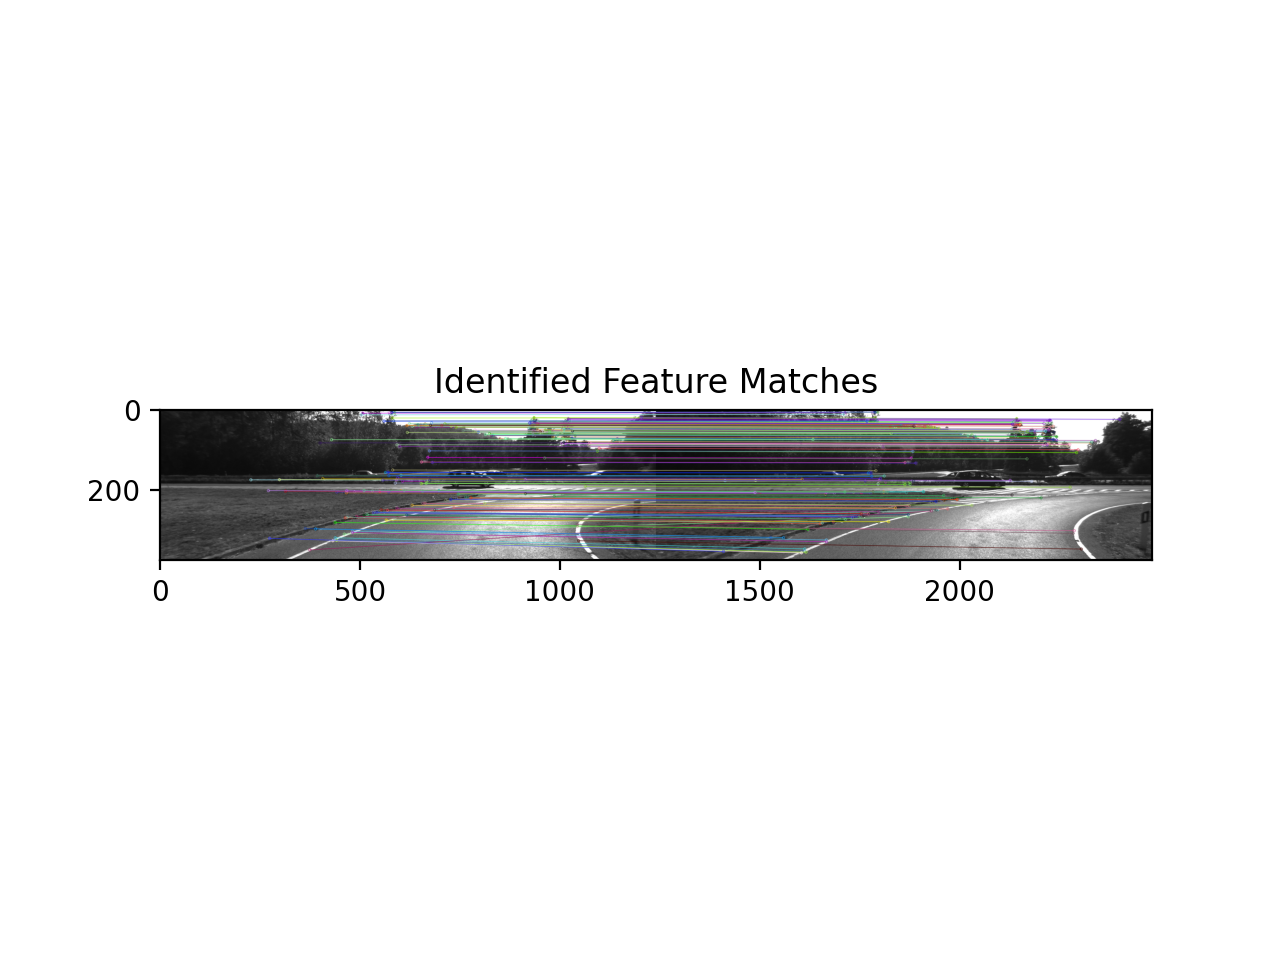

In [3]:
gctx.plot_img_feature_matches()

From these essential matrixes, we can make a first-pass at estimating the robot's trajectory:

<IPython.core.display.Javascript object>


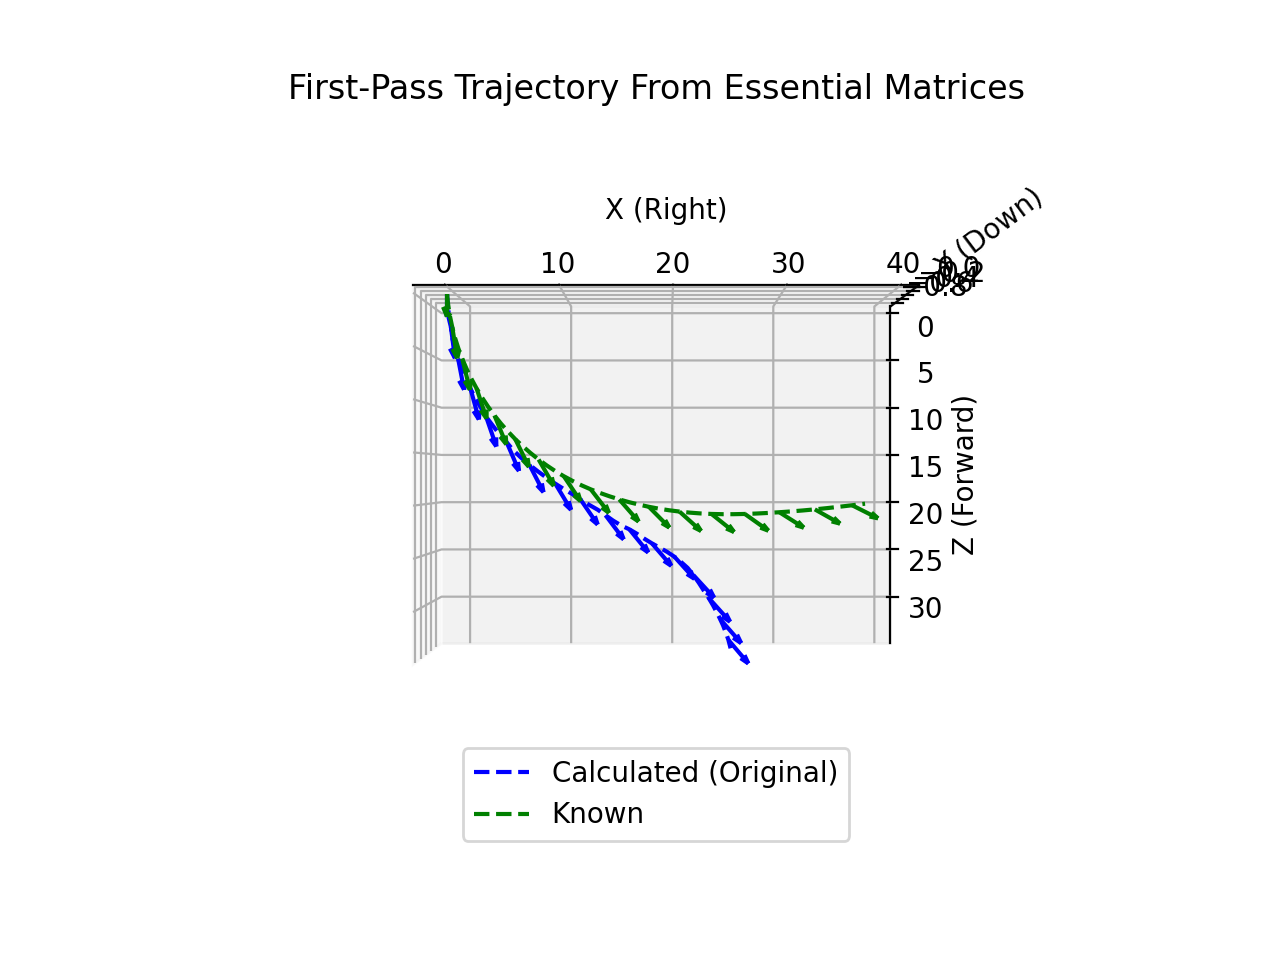

In [4]:
gctx.plot_trajectories(['original', 'known'], title='First-Pass Trajectory From Essential Matrices', arrows=True)

This looks pretty good for the first part, although it goes right off the tracks about half way through. I'm not sure why--but it's probably what I'd investigate next given more time.

### Step 2: Bundle Adjustment

Whereas Step 1 only uses pairs of frames, bundle adjustment takes advantage of the fact that we track some features over _many_ frames. It uses that information to refine the estimates of camera positions and of the features' positions in 3D space. Here's how it does that:

1. Project the 3D position of each feature into the 2D space of each camera that the feature appeared in, using the current estimated positions of the cameras and the feature.
2. Calculate the difference between the projected 2D positions and the observed 2D positions. This is the reprojection error.
3. Plug all of that into SciPy, and till it to optimize the 3D positions of each camera and feature by minimizing reprojection error. It is very good at this, and regularly goes from ~$10^{10}$ to <$10^{-10}$ of reprojection error

Unfortunately, I discovered at the last minute that bundle adjustment was introducing substantial error into the process, so this step is currently disabled. This would be an important thing to look into given more time.

The error added by bundle adjustment can be seen in these graphs:

<IPython.core.display.Javascript object>


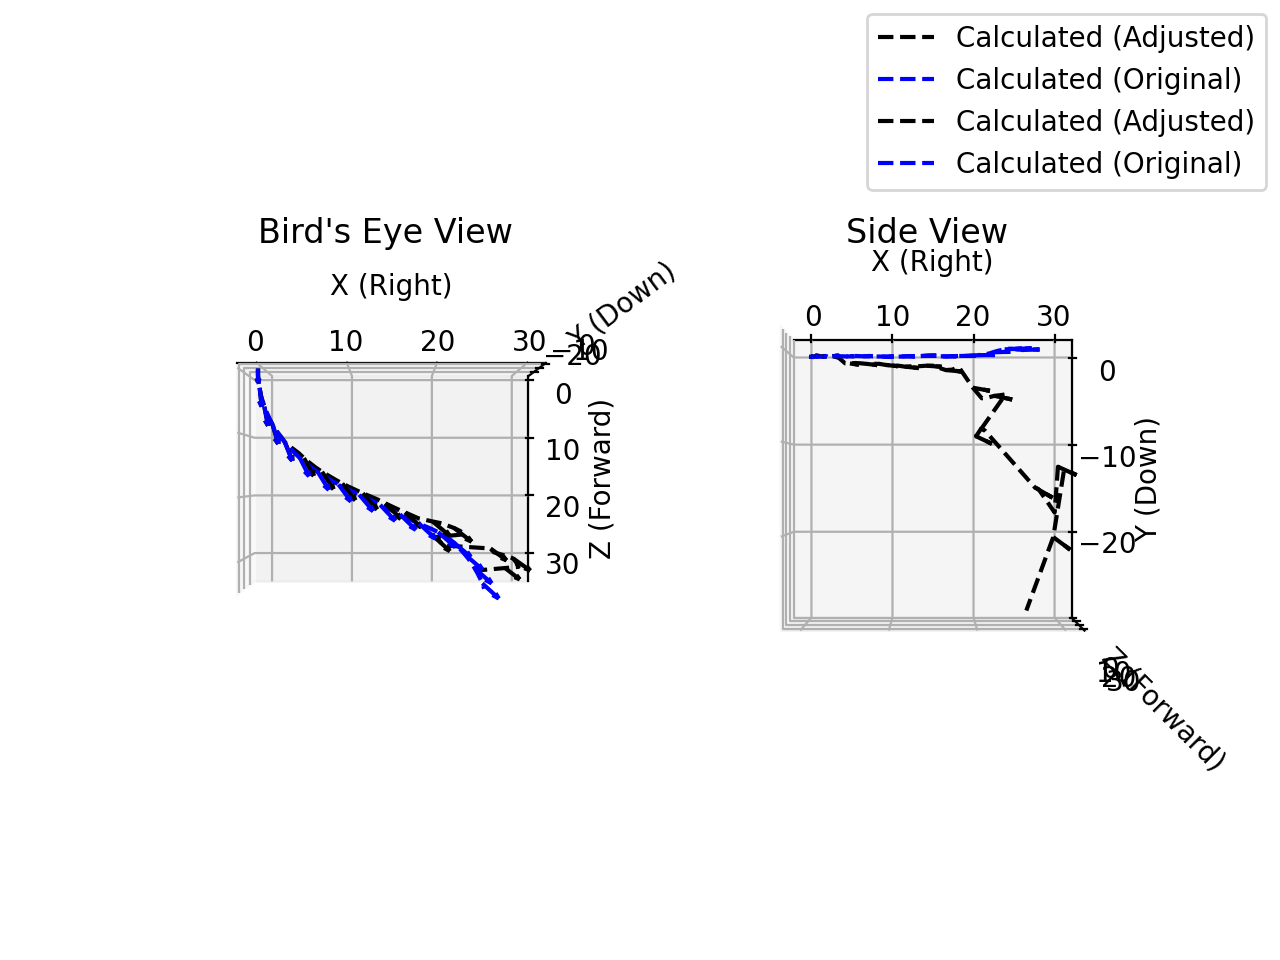

In [26]:
fig, (ax0, ax1) = plt.subplots(1, 2, subplot_kw=dict(projection="3d"))

gctx.plot_trajectories(['adjusted', 'original'], ax=ax0, title='Bird\'s Eye View', arrows=True, view=(180,-90), legend=False)
gctx.plot_trajectories(['adjusted', 'original'], ax=ax1, title='Side View', arrows=True, view=(90,-90), legend=False)

fig.legend()

### Step 3: Scale Factor

This step addresses the issue that visual odometry has no sense of scale--without a point of reference, it can't tell if you've gone a millimeter or a kilometer. (This only applies to translation, rotation can be accurately determined.)

We solve this issue by cheating, and using the ground truth provided by KITTI. For each frame, scale the translation (but not the rotation) such that the magnitude of the translation vector is equal to the magnitude of the ground truth's translation vector. In a real-world environment without ground truth, the scale factor might be determined by, say, an IMU.

Interestingly, the scale factors generated are almost always very close to one, resulting in minimal changes from this step... I think the KITTI dataset might be normalized such that the translation vector always has magnitude one, although I'm not sure. That behavior wouldn't make a lot of sense (I'd expect KITTI to be normalized to, say, meters).

<IPython.core.display.Javascript object>


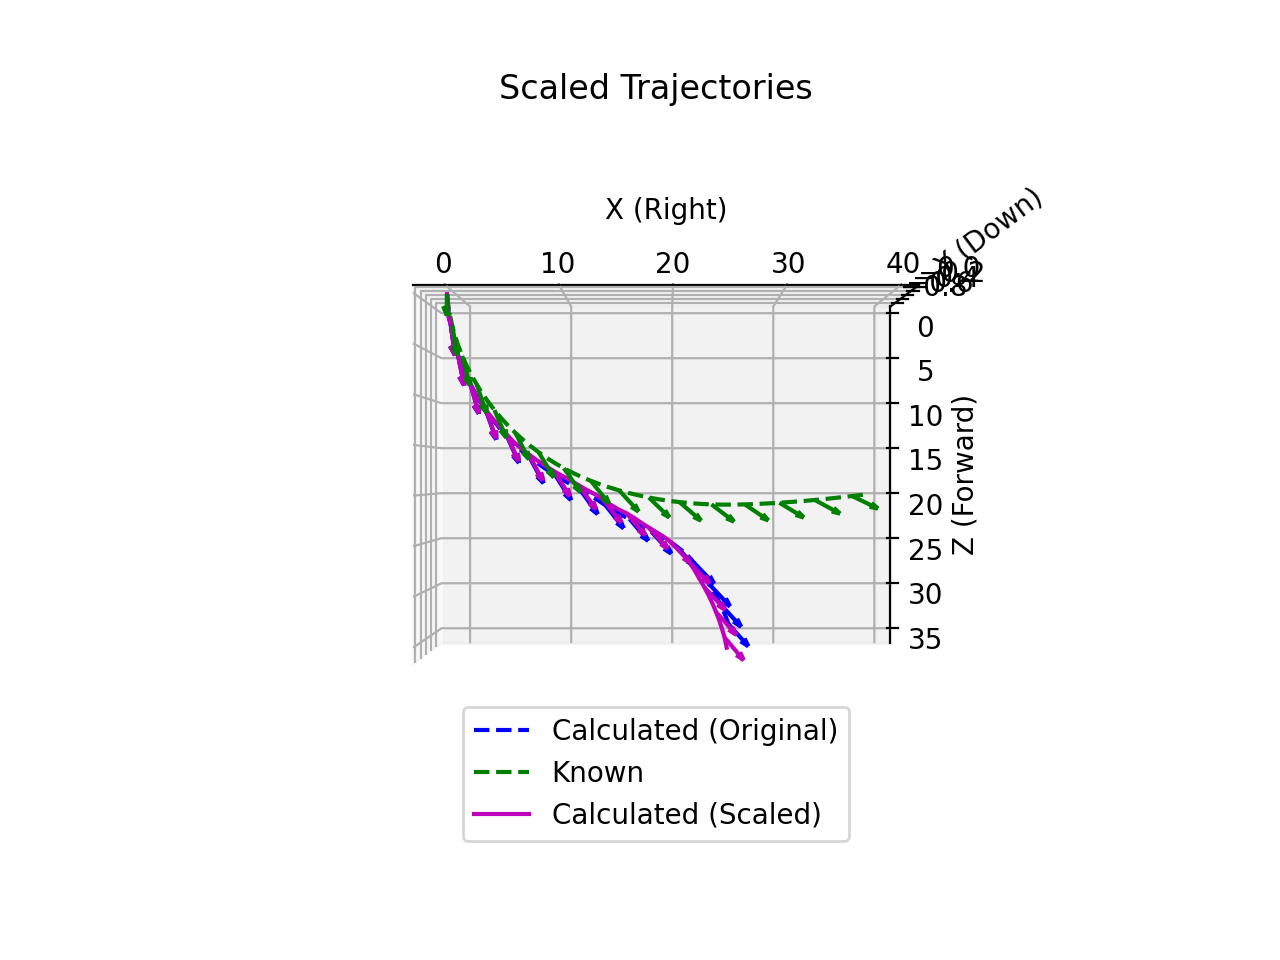

In [19]:
gctx.plot_trajectories(['original', 'scaled', 'known'], title='Scaled Trajectories', arrows=True)

### Step 4: Error Calculation

Finally, we calculate how accurate the system was. We do this on a per-axis and per-frame basis, comparing the computed and ground truth values. Notably, we compare the relative movements from frame-to-frame, not the accumulated position--since any visual odometry system will accumulate error over time. (In the real world, this is solved by occasionally resetting to a known location using GPS or AprilTags.) The formula used is $\text{Error}_t = \frac{\left|X_\text{known, t}\right| - \left| X_\text{calculated, t} \right|}{\left|X_\text{known, t}\right|}$

Here, we can see that the accuracy of the system isn't bad until the odometry veers off to the right (the graph is limited to data below the 95th percentile, to hide the extreme outliers caused by that turn). In the second graph, we can see a zoomed-in version focusing on just the first ten frames, which shows great performance (albeit with decreasing accuracy over time).

Note that for the reasons mentioned previously, the Y-axis is mostly noise and the error shown on it isn't a cause for concern.


<IPython.core.display.Javascript object>


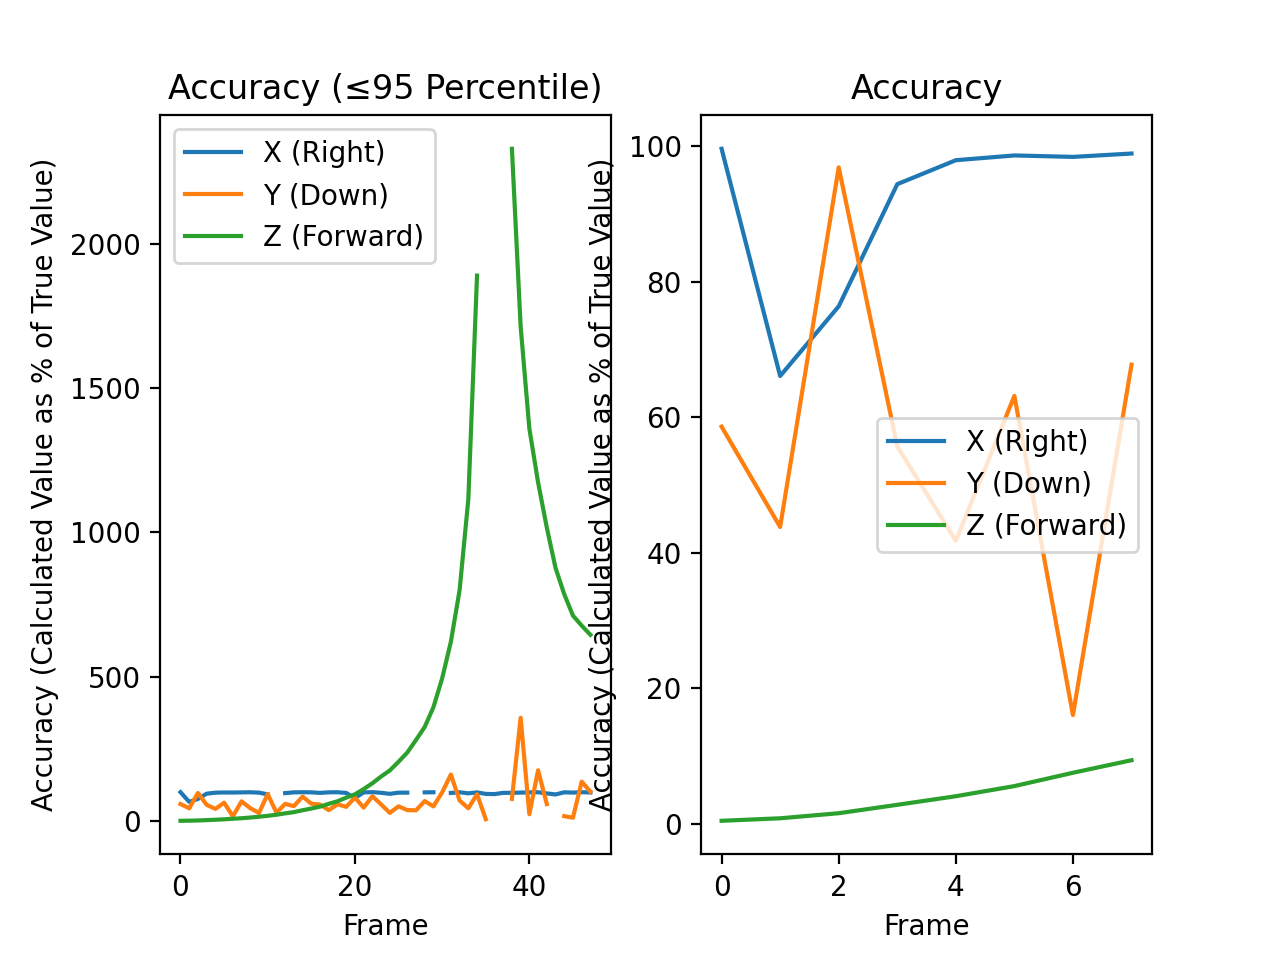

In [25]:
fig, (ax0, ax1) = plt.subplots(1, 2)
gctx.plot_error(percentile=95, ax=ax0)
gctx.plot_error(percentile=100, end=10, ax=ax1)

## Conclusion

Overall, I'm very pleased with how this project turned out. I learned a _ton_ about computer vision and visual odometry, and while the project is obviously basic, I'm pleasantly surprised with how well it works.

If I had more time to complete this project, I would have further investigated why the odometry starts veering off course part way through, and why bundle adjustment introduces error instead of removing it. I suspect the former is due to not implementing PnP as Baggio et al. described (I previously did implement it, but it was causing separate issues because it doesn't support generating relative transforms) and instead using triangulation throughout. I suspect the latter is due to a malformed residual function passed to SciPy's optimizer, but I'm less confident about that.

Additionally, the code for this project—while not attrocious—definitely isn't the most well-organized code I've ever written. I'm not terribly concerned about that since the focus of this project was learning the algorithm, but it would be a good thing to improve on in the future.

## Acknowledgements

Thank you so much to Paul Ruvolo, my advisor throughout this independent study. I wouldn't have been able to acomplish this without him, and I'm beyond grateful for his help, support, and guidance.